In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
dataset = pd.read_csv('Dataset/habz_dataset.csv')

dataset.columns = dataset.columns.str.lower().str.replace(" ","_")

X = dataset[['energi_(kal)', 'protein_(g)', 'lemak_(g)','gula_(g)', 'serat_(g)', 'natrium_(mg)']].values
y = dataset['grade'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

normalizer = Normalization()
normalizer.adapt(X)

In [5]:
def create_model(input_dim, output_dim):
    model = Sequential([
        normalizer,
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
best_model = None
best_history = None
best_acc = 0

for train_index, test_index in kf.split(X):
    print(f'\n--- Fold {fold_no} ---')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    model = create_model(X_train.shape[1], y_categorical.shape[1])

    # Callback untuk early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    scores = model.evaluate(X_test, y_test, verbose=0)
    acc = scores[1] * 100
    print(f"Fold {fold_no} Accuracy: {acc:.2f}%")

    acc_per_fold.append(acc)

    # Simpan model terbaik
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_history = history

    fold_no += 1



--- Fold 1 ---
Epoch 1/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6478 - loss: 0.8481 - val_accuracy: 0.8650 - val_loss: 0.3399
Epoch 2/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8434 - loss: 0.4039 - val_accuracy: 0.9031 - val_loss: 0.2610
Epoch 3/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8703 - loss: 0.3347 - val_accuracy: 0.9136 - val_loss: 0.2280
Epoch 4/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8824 - loss: 0.3079 - val_accuracy: 0.9153 - val_loss: 0.2213
Epoch 5/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8859 - loss: 0.2859 - val_accuracy: 0.9145 - val_loss: 0.2060
Epoch 6/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8927 - loss: 0.2656 - val_accuracy: 0.9248 - val_loss: 0.1984
Epoch 7/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8965 - loss: 0.2588 - val_accuracy: 0.9221 - val_loss: 0.1922
Epoch 8/100
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - ac


Best Model Accuracy: 94.69%


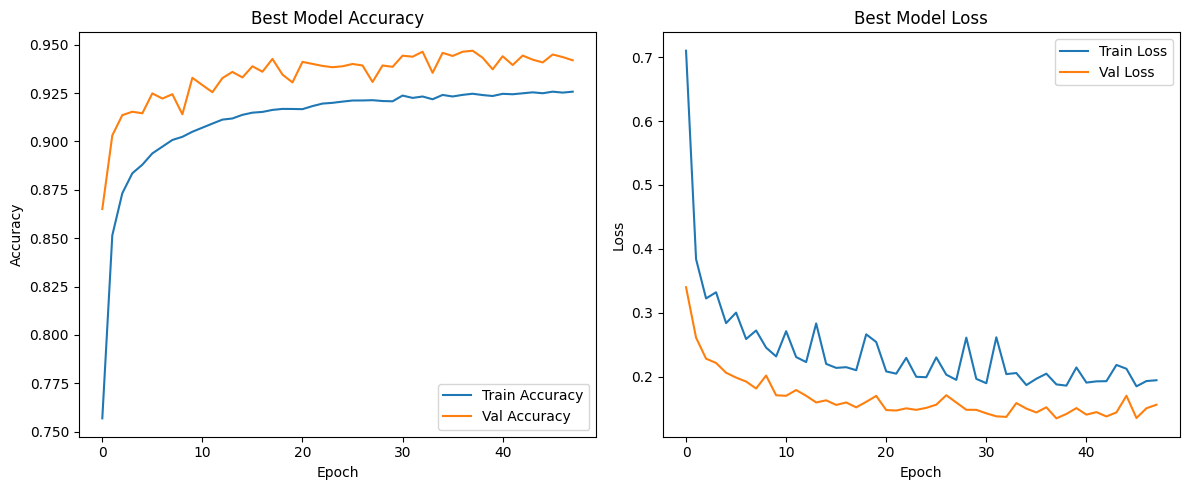

In [11]:
print(f'\nBest Model Accuracy: {best_acc:.2f}%')

plt.figure(figsize=(12,5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Best Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Val Loss')
plt.title('Best Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
best_model.save('best_model_biteMate.h5')
print("✅ Model terbaik telah disimpan sebagai 'best_model_biteMate.h5'")

# Rata-rata akurasi semua fold
print('\nAverage accuracy across folds:', np.mean(acc_per_fold), '%')

✅ Model terbaik telah disimpan sebagai 'best_model_biteMate.h5'

Average accuracy across folds: 94.4180428981781 %
